In [1]:
!nvidia-smi

Wed Apr 26 15:44:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    21W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

try:
    import lovely_tensors as lt
except:
    ! pip install --upgrade lovely-tensors
    import lovely_tensors as lt
    
lt.monkey_patch()

In [4]:
# !rm -rf /app/notebooks/siren_sdf/checkpoints/*

In [5]:
config = {
    "device": torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu"),
    "wandb_project": "siren_sdf",
    "experiment_name": "thai_statue_splitact_baseline_with_5mult",
    "logging": True,
    "point_cloud_path": "data/thai_statue.xyz",
    "batch_size": 25_000,
    "clip_grad": True,
    "checkpoint_dir": Path('checkpoints/'),
    "save_ckpt_freq": 10_000,
    "vis_freq": 2_500,
    "epochs": 10000,
    
    "lr": 1e-4,
    "iteration_on_stop": 50_000,
    "hidden_features": 64,
    "num_hidden_layers": 2,
    "net_type": 'split_act',
}

config["checkpoint_dir"].mkdir(exist_ok=True, parents=True)

# Train SDF

In [6]:
# !pip install scikit-image==0.20.0 scikit-video==1.1.11 opencv-python==4.7.0.72 cmapy==0.6.6 ConfigArgParse==1.5.3 plyfile==0.9 -q
# !pip uninstall scipy -y; pip install scipy

In [7]:
import src.dataio as dataio
from torch.utils.data import DataLoader
from src.utils import get_sdf_summary
from src.sdf_meshing import create_mesh

In [8]:
sdf_dataset = dataio.PointCloud(config['point_cloud_path'], on_surface_points=config['batch_size'])
dataloader = DataLoader(sdf_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

Loading point cloud
Finished loading point cloud


In [9]:
from src.nn_modules import SingleBVPNet, SplitNetManager
    
model = SingleBVPNet(type=config['net_type'], in_features=3, hidden_features=config['hidden_features'], num_hidden_layers=config['num_hidden_layers']).to(config['device'])
# if config.get('load_from_checkpoint_path') is not None and Path(config['load_from_checkpoint_path']).exists():
#     model.load_state_dict(torch.load(config['load_from_checkpoint_path']))

In [10]:
net_manager = SplitNetManager(model)

In [11]:
for step, (model_input, gt) in enumerate(dataloader):
    model_input = {key: value.to(config['device']) for key, value in model_input.items()}
    gt = {key: value.to(config['device']) for key, value in gt.items()}
    break

In [12]:
model_input['coords']

tensor[1, 50000, 3] n=150000 x∈[-1.000, 1.000] μ=-0.092 σ=0.501 cuda:0

Input to the network


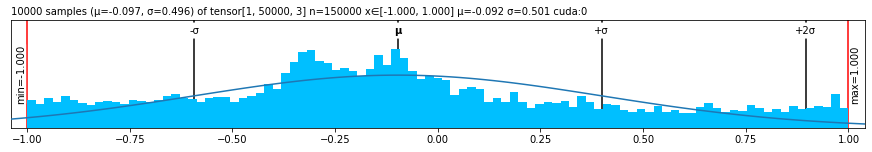

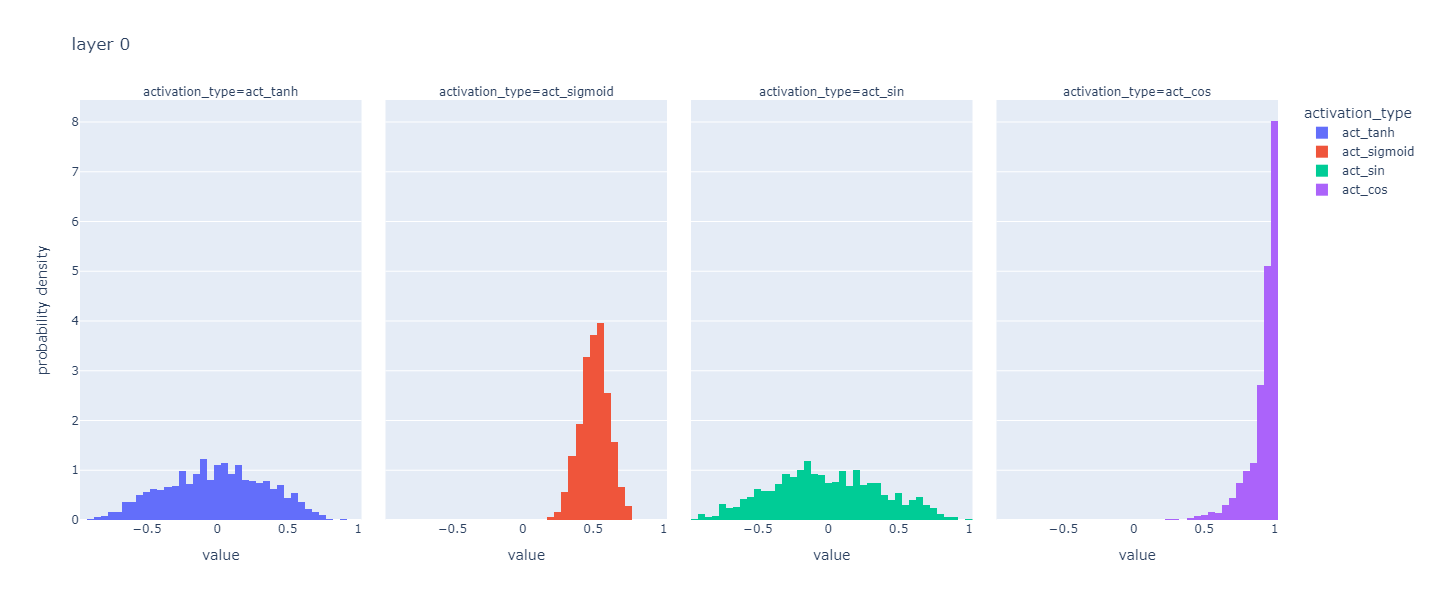

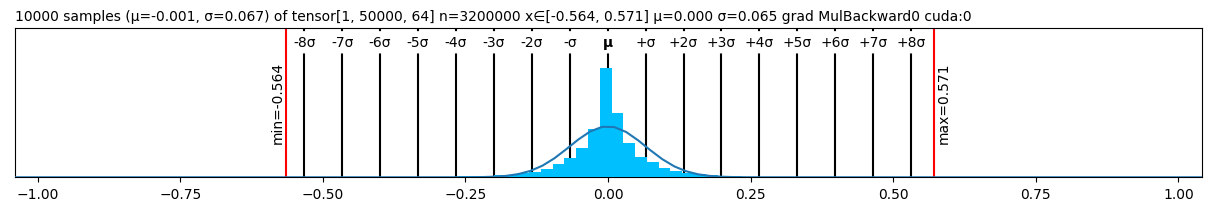

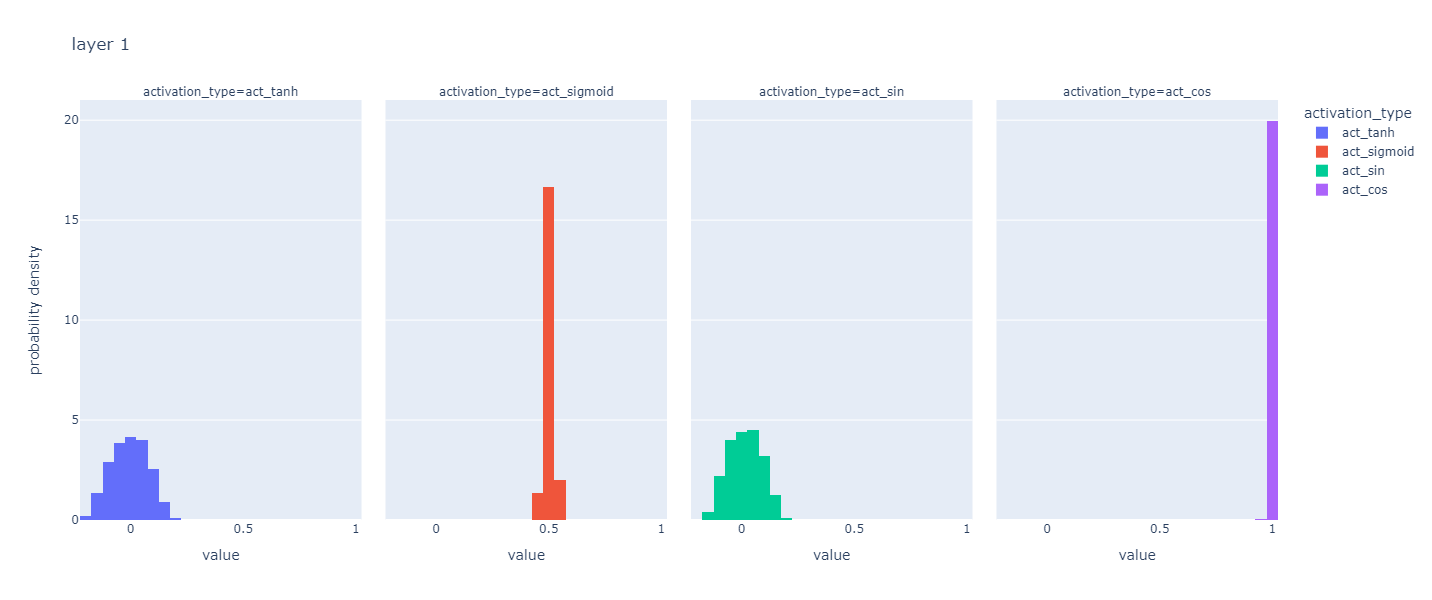

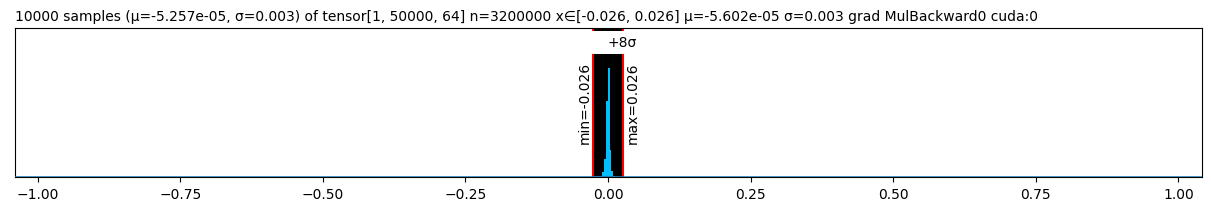

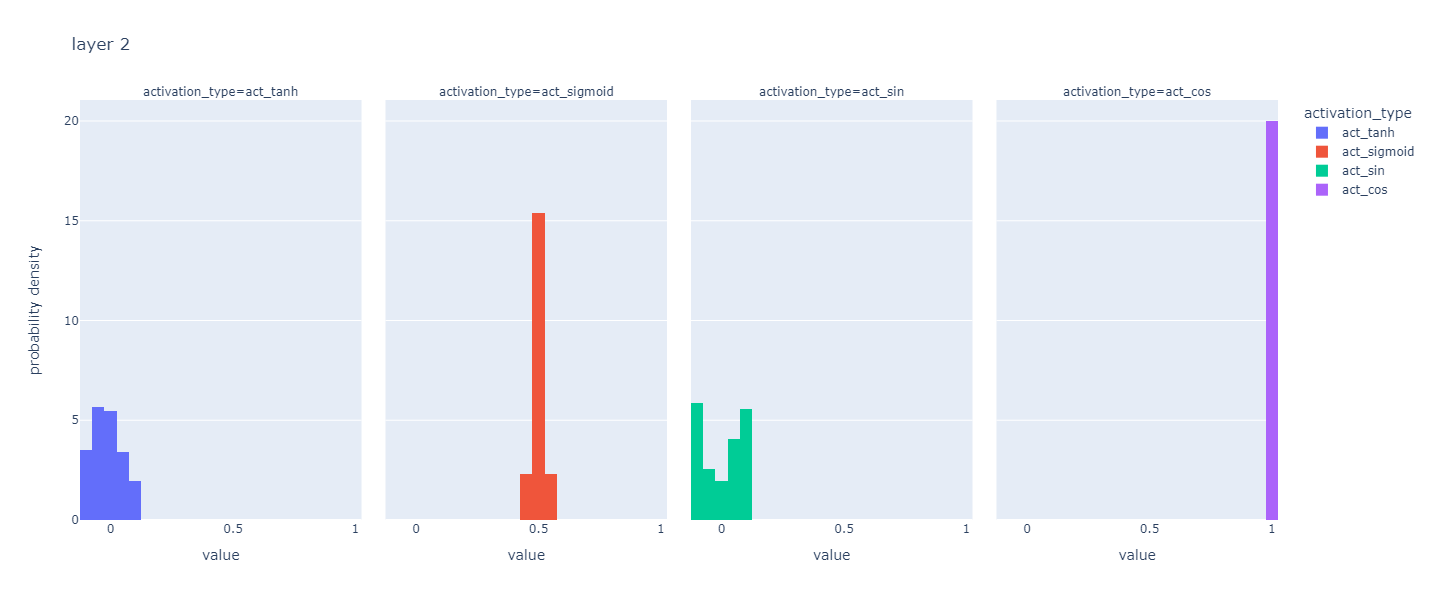

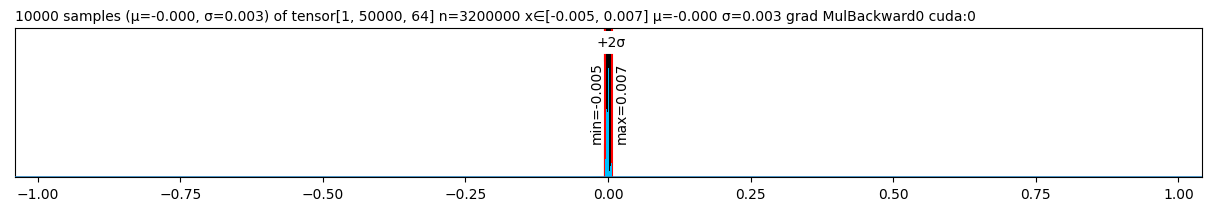

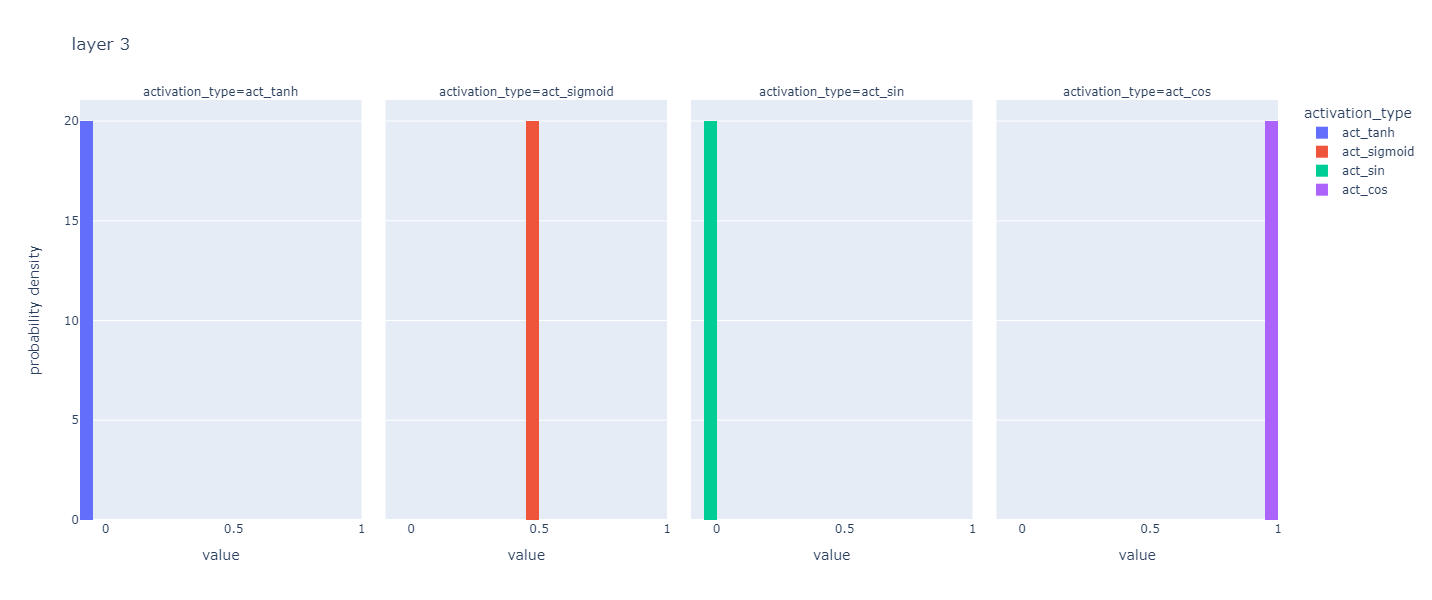

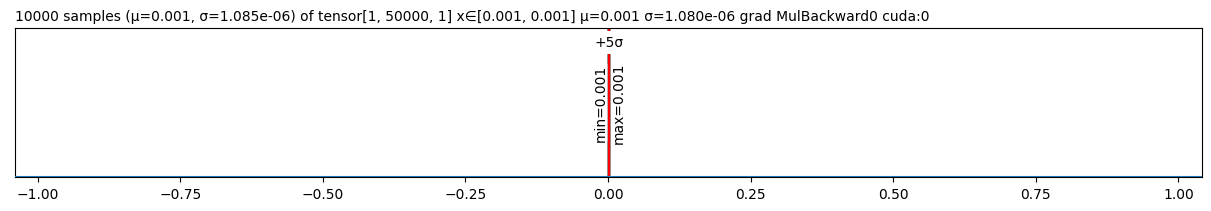

In [13]:
net_manager.plot_activations(model_input)

In [14]:
from src.loss_functions import sdf

optimizer = torch.optim.Adam(lr=config['lr'], params=model.parameters())

In [15]:
import wandb
if config['logging']:
    run = wandb.init(project=config["wandb_project"], name=config["experiment_name"], config=config)

wandb: Currently logged in as: nerlfield. Use `wandb login --relogin` to force relogin


In [16]:
from tqdm.auto import tqdm

iteration = 0
for epoch in (pbar := tqdm(range(int(config['epochs'])))):
    for step, (model_input, gt) in enumerate(dataloader):
        model_input = {key: value.to(config['device']) for key, value in model_input.items()}
        gt = {key: value.to(config['device']) for key, value in gt.items()}
        
        model_output = model(model_input)
        losses = sdf(model_output, gt)
        
        train_loss = 0.
        for loss_name, loss in losses.items():
            single_loss = loss.mean()
            train_loss += single_loss
                
        if config['logging']:
            wandb.log({
                "sdf": losses['sdf'].item(),
                "inter": losses['inter'].item(),
                "normal_constraint": losses['normal_constraint'].item(),
                "grad_constraint": losses['grad_constraint'].item(),
                "train_loss": train_loss.item()
            })
            
        optimizer.zero_grad()
        train_loss.backward()

        if config['clip_grad']:
            if isinstance(config['clip_grad'], bool):
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['clip_grad'])

        optimizer.step()
        
        if iteration % config['vis_freq'] == 0 and config['logging']:
            sdf_summary = get_sdf_summary(model, model_input, gt, model_output)
            wandb.log({
                "xy_sdf_slice": wandb.Image(sdf_summary['xy_sdf_slice']),
                "xz_sdf_slice": wandb.Image(sdf_summary['xz_sdf_slice']),
                "yz_sdf_slice": wandb.Image(sdf_summary['yz_sdf_slice'])
            })
            
        if iteration % config['save_ckpt_freq'] == 0:
            torch.save(model.state_dict(), config['checkpoint_dir'] / f"{config['wandb_project']}_{config['experiment_name']}_{epoch}_{iteration}.pth")
        
        pbar.set_description(f' => Loss: {train_loss.item():.3f}')
        
        iteration += 1
        
        if iteration > config['iteration_on_stop']:
            break
    if iteration > config['iteration_on_stop']:
            break

  0%|          | 0/10000 [00:00<?, ?it/s]

/app/notebooks/siren_sdf/src/utils.py:72: UserWarning:

No contour levels were found within the data range.

/app/notebooks/siren_sdf/src/utils.py:73: UserWarning:

No contour levels were found within the data range.



In [17]:
import rff

hs = 64

encoded_size = hs//2

encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=3, encoded_size=encoded_size).to(config['device'])

In [18]:
model_input['coords']

tensor[1, 50000, 3] n=150000 x∈[-1.000, 1.000] μ=-0.090 σ=0.502 cuda:0

In [19]:
encoding(model_input['coords'])

tensor[1, 50000, 64] n=3200000 x∈[-1.000, 1.000] μ=-0.001 σ=0.707 cuda:0

In [20]:
# !pip install random-fourier-features-pytorch

# Save to mesh

In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from src.nn_modules import SingleBVPNet

class SDFDecoder(torch.nn.Module):
    def __init__(self, config, ckpt_path=None):
        super().__init__()
        # Define the model.
        self.model = SingleBVPNet(type=config['net_type'], in_features=3, hidden_features=config['hidden_features'], num_hidden_layers=config['num_hidden_layers'])
        if ckpt_path is not None:
            self.model.load_state_dict(torch.load(ckpt_path))
        self.model = self.model.to(config['device'])

    def forward(self, coords):
        model_in = {'coords': coords}
        return self.model(model_in)['model_out']

In [ ]:
decoder = SDFDecoder(config, config['checkpoint_dir'].ls()[-1])

In [ ]:
create_mesh(decoder, config['experiment_name'], device=config['device'], N=700)